In [1]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

In [2]:
from core.cluster_validation import generate_validation_groups, colored_crosstab
from core.utils import used_keys

In [3]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

In [4]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [5]:
# region_id = 4182

# tessellations_dir = graph_dir = '../data/ms_buildings/'
# chars_dir = '../data/ms_buildings/chars/'

In [6]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
X_train = X_train[X_train.index >= 0]
X_train = X_train.clip(-10, 10)

In [7]:
# spatial_lag = 3
# X_train = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

In [8]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [9]:
tess_groups = generate_validation_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=1_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [10]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

15 2 100 0.0 -- 3.8382380231747195
25 2 100 0.0 -- 3.327252543865024
50 2 100 0.0 -- 3.5900276603217316
100 2 100 0.0 -- 3.8738398385827377


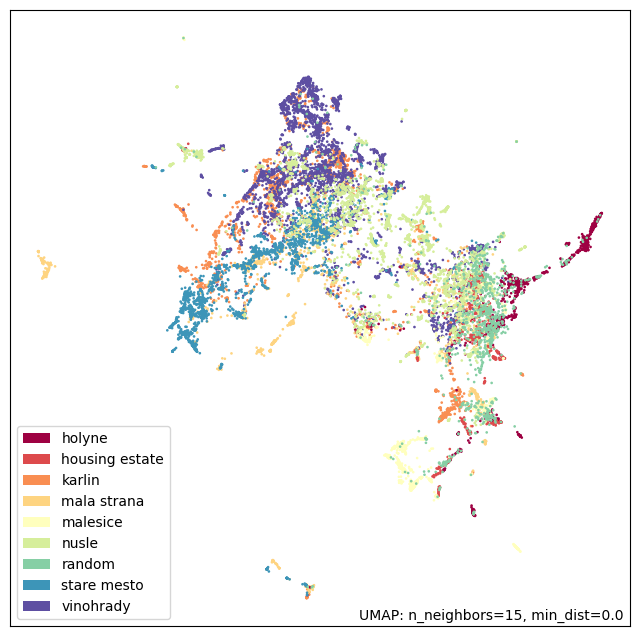

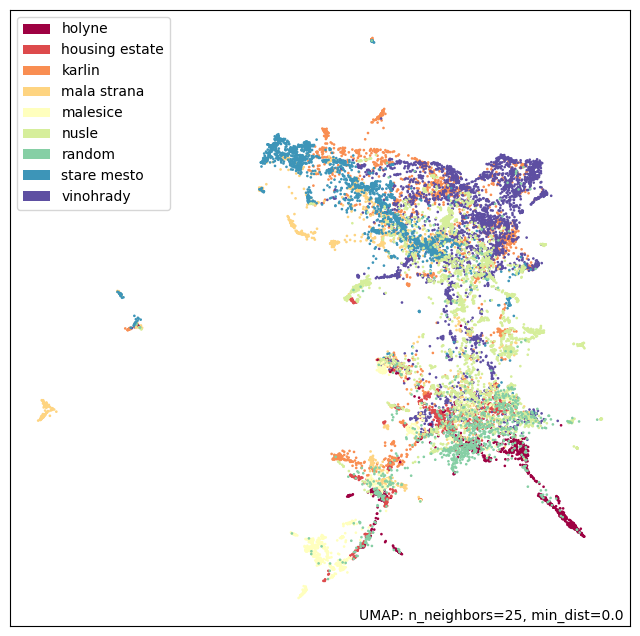

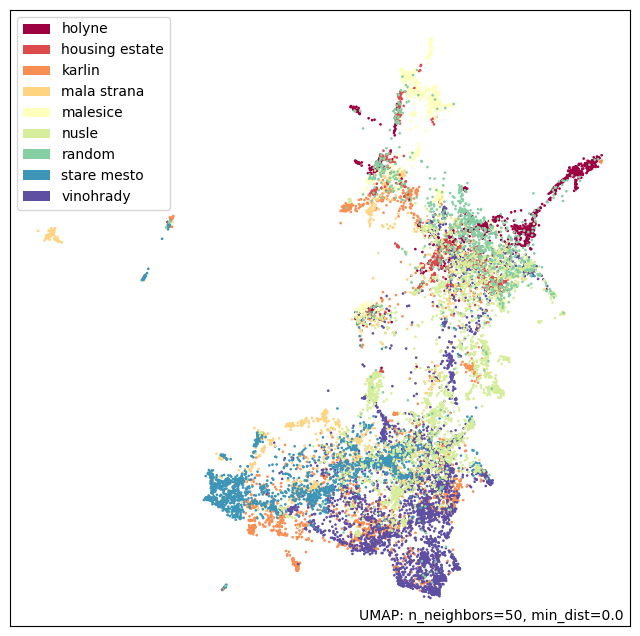

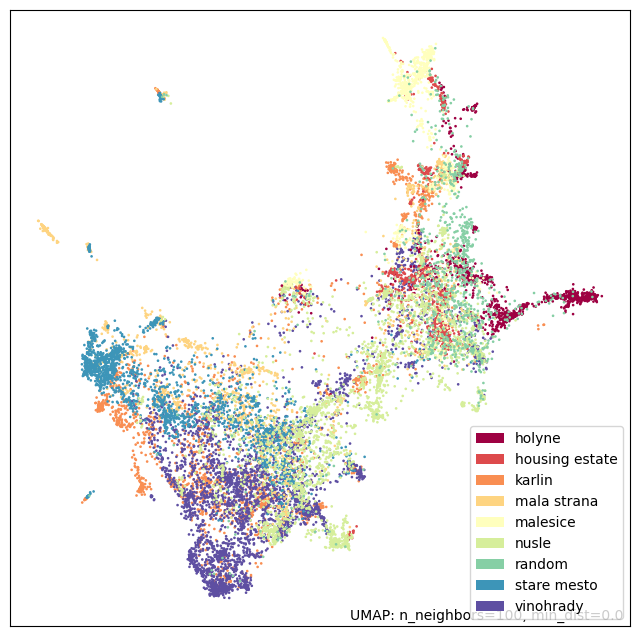

In [11]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.0)

In [12]:
data = X_train.values

In [13]:
n_neighbors = 50
negative_sample_rate = 25
n_epochs = 500

noise_level = 0.5

neighbor_scale = 1.0
symmetrize_graph = True
node_embedding_dim = 2

In [14]:
from evoc.knn_graph import knn_graph
from evoc.graph_construction import neighbor_graph_matrix

/home/krasen/evoc/evoc/float_nndescent.py:287: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  points = point_indices[i]


In [15]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [16]:
%%time
nn_inds, nn_dists = knn_graph(data, n_neighbors=n_neighbors)


CPU times: user 2min 52s, sys: 864 ms, total: 2min 53s
Wall time: 13 s


In [17]:
# %%time
# from fast_hdbscan.numba_kdtree import kdtree_to_numba
# from fast_hdbscan.numba_kdtree import parallel_tree_query

# from sklearn.neighbors import KDTree

# sklearn_tree = KDTree(data)
# numba_tree = kdtree_to_numba(sklearn_tree)
# result = parallel_tree_query(numba_tree, np.ascontiguousarray(data), k=n_neighbors)

# nn_dists, nn_inds = result

In [18]:
# app_nn_inds, app_nn_dists = knn_graph(data, n_neighbors=n_neighbors)

In [19]:
%%time

graph = neighbor_graph_matrix(
    neighbor_scale * n_neighbors, nn_inds, nn_dists, symmetrize_graph
)

CPU times: user 3.7 s, sys: 161 ms, total: 3.86 s
Wall time: 1.5 s


In [20]:
from evoc.label_propagation import label_propagation_init

In [21]:
%%time
init_embedding = label_propagation_init(
            graph,
            n_components=node_embedding_dim or min(n_neighbors, 15),
            approx_n_parts=np.clip(int(np.sqrt(data.shape[0])), 100, 1024),
            random_scale=0.1,
            scaling=0.5,
            noise_level=noise_level,
        )

CPU times: user 22.5 s, sys: 40.1 ms, total: 22.6 s
Wall time: 1.58 s


In [22]:
from evoc.node_embedding import node_embedding

In [23]:
graph = graph.tocoo()

In [24]:
%%time
embedding = node_embedding(
        graph,
        n_components=node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=init_embedding,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        verbose=True,
    )

/home/krasen/evoc/evoc/node_embedding.py:13: RuntimeWarning: overflow encountered in divide
  result[n_samples > 0] = float(n_epochs) / np.float32(n_samples[n_samples > 0])


CPU times: user 6min 35s, sys: 238 ms, total: 6min 35s
Wall time: 23.2 s


In [25]:
def plot_datashade_umap(embedding, labels=None, n_neighbors=0.0, min_dist=0.0):
    class MockEmbedding(object):
        pass
    
    enb = MockEmbedding()
    enb.embedding = embedding
    enb.n_neighbors = n_neighbors
    enb.min_dist = 0.0

    if labels is None:
        return umap.plot.points(enb)
    
    return umap.plot.points(enb, labels=labels)

<Axes: >

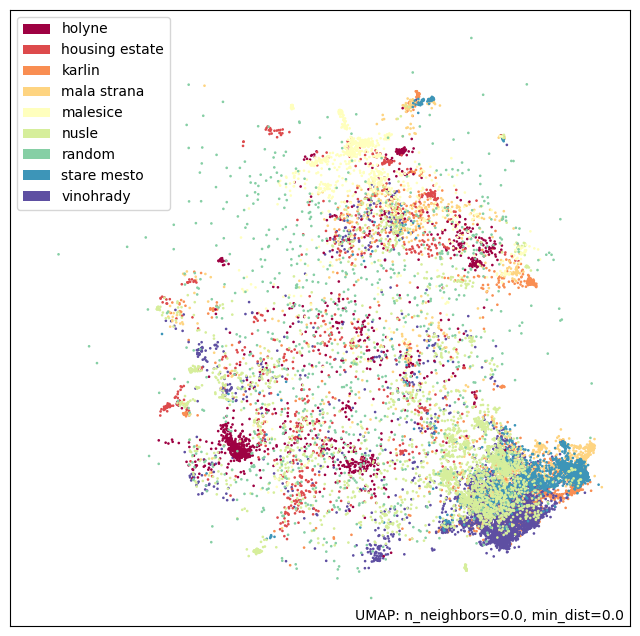

In [26]:
plot_datashade_umap(embedding[tess_groups_ilocs], tess_groups.values)

In [27]:
# x, y = tessellation.loc[tess_groups.index].representative_point().x.values, tessellation.loc[tess_groups.index].representative_point().y.values

In [28]:
rps = tessellation[tessellation.index.isin(X_train.index)].representative_point()
x, y = rps.x.values, rps.y.values

In [29]:
spatial_init = np.vstack((x,y)).T
spatial_init = StandardScaler().fit_transform(spatial_init)
spatial_init = np.ascontiguousarray(spatial_init, dtype=np.float32)

<Axes: >

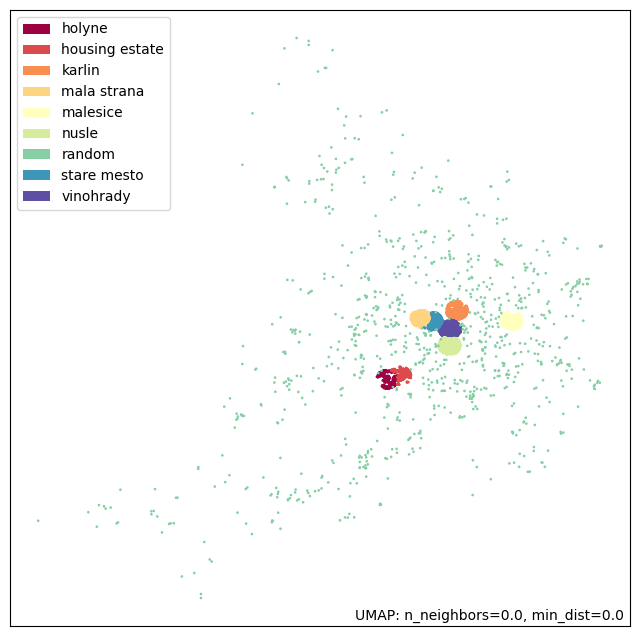

In [30]:
plot_datashade_umap(spatial_init[tess_groups_ilocs], tess_groups.values)

In [34]:
learning_rate = .5
# negative_sample_rate = 50
# noise_level = .01
# n_epochs = 10000

In [35]:
%%time
spatial_embedding = node_embedding(
        graph,
        n_components=node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=spatial_init,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        initial_alpha=learning_rate,
        verbose=False,
    )

/home/krasen/evoc/evoc/node_embedding.py:13: RuntimeWarning: overflow encountered in divide
  result[n_samples > 0] = float(n_epochs) / np.float32(n_samples[n_samples > 0])


CPU times: user 6min 34s, sys: 280 ms, total: 6min 34s
Wall time: 23.3 s


In [121]:
# plot_datashade_umap(spatial_embedding[tess_groups_ilocs], tess_groups.values)

In [122]:
# plot_datashade_umap(spatial_embedding)

In [120]:
# plot_datashade_umap(embedding)

In [38]:
%%time

from evoc.clustering import build_cluster_layers
min_num_clusters = 4
min_samples = n_neighbors * 2
base_min_cluster_size = n_neighbors
next_cluster_size_quantile = .8

cluster_layers, membership_strengths = build_cluster_layers(
            embedding,
            min_clusters=min_num_clusters,
            min_samples=min_samples,
            base_min_cluster_size=base_min_cluster_size,
            next_cluster_size_quantile=next_cluster_size_quantile,
)

CPU times: user 3min 36s, sys: 2.42 s, total: 3min 38s
Wall time: 3min 28s


In [135]:
# %%time

# from core.generate_streets import record_batch_reader

# region_name = 69300
# regions_datadir = "/data/uscuni-ulce/"
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "regions_hull.parquet"
#     )
# region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.to_crs(epsg=4326).loc[region_name].convex_hull

# batches = record_batch_reader('division_area', bbox=region_hull.bounds).read_all()
# gdf = gpd.GeoDataFrame.from_arrow(batches)
# gdf = gdf.iloc[gdf.sindex.query(region_hull, predicate='intersects')]

# prague_neighbourhoods = gdf[gdf['subtype'] == 'locality'].set_crs(epsg=4326)
# prague_neighbourhoods['names'] = prague_neighbourhoods['names'].apply(lambda x: x['primary'])
# prague_neighbourhoods = prague_neighbourhoods[['geometry', 'names']].to_crs(epsg=3035)
# prague_neighbourhoods.to_parquet('../data/prague_neighbourhoods.parquet')

In [218]:
# import bokeh
# prague_neighbourhoods = gpd.read_parquet('../data/prague_neighbourhoods.parquet')

In [220]:
# umap.plot.output_notebook()


In [221]:
# plotting = tessellation.copy()
# plotting = plotting[plotting.index.isin(X_train.index)]
# inp, res = plotting.representative_point().sindex.query(prague_neighbourhoods.geometry, predicate='intersects')

In [222]:
# class MockEmbedding(object):
#     pass

# enb = MockEmbedding()
# enb.embedding = spatial_embedding[res]
# enb.n_neighbors = n_neighbors
# enb.min_dist = 0.0

In [223]:
# hover_data = X_train.iloc[res, :2]
# hover_data['label'] = prague_neighbourhoods.iloc[inp, 1].values

In [224]:
# p = umap.plot.interactive(enb, hover_data=hover_data, point_size=2)
# umap.plot.show(p)

In [87]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [92]:

min_cluster_size = n_neighbors

In [109]:
%%time
sklearn_tree = KDTree(embedding)

# sklearn_tree = KDTree(spatial_embedding)

numba_tree = kdtree_to_numba(sklearn_tree)
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)
sorted_mst = edges[np.argsort(edges.T[2])]
linkage_tree = mst_to_linkage_tree(sorted_mst)
condensed_tree = condense_tree(linkage_tree, min_cluster_size=50)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

CPU times: user 4.41 s, sys: 27.4 ms, total: 4.44 s
Wall time: 457 ms


In [110]:
# clusters = cluster_layers[4]

In [111]:
np.unique(clusters, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

In [112]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [113]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters
plotting = plotting[plotting["label"] >= 0]

In [114]:
def get_color(labels_to_color):

    import glasbey
    
    def hex_to_rgb(hexa):
        return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))
    
    if plotting["label"].max() > 12:
        gb_cols = glasbey.extend_palette(
            Set3_12.hex_colors, palette_size=np.unique(labels_to_color).shape[0] + 1
        )
    else:
        gb_cols = Set3_12.hex_colors
    
    gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]
    
    colors = apply_categorical_cmap(
        plotting["label"], cmap=dict(zip(np.unique(labels_to_color), gb_cols, strict=False))
    )
    return colors

In [115]:
colors = get_color(clusters)

In [116]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [119]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m